Importing files

In [111]:
import tensorflow as tf
import json
import os
import unicodedata
import re
import logging
import pickle
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import time
from PIL import Image

Downloading Captions from MS-COCO dataset

In [17]:
#https://www.tensorflow.org/tutorials/text/image_captioning
annotation_directory = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_directory):
  annotation_tar = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
  annotation_files = os.path.dirname(annotation_tar)+'/annotations/captions_train2014.json'
  os.remove(annotation_tar)

252878848/252872794 [==============================] - 2s 0us/step


Downloading images from MS-COCO dataset

In [3]:
#https://www.tensorflow.org/tutorials/text/image_captioning
image_directory = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_directory):
  image_tar = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
  PATH = os.path.dirname(image_tar) + image_directory
  os.remove(image_tar)
else:
  PATH = os.path.abspath('.') + image_directory

Function for reading JSON file

In [5]:
def open_json_file(file_name):
    with open(file_name, 'r') as f:
        annotations = json.load(f)
    return annotations

Function for saving pickle files

In [6]:
def save_file(d, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(d, f, protocol=2)
    f.close()

Function for removing HTML noise from text

In [7]:
def remove_html_markup(s):
    tag = False
    quote = False
    out = ""
    for c in s:
        if c == '<' and not quote:
            tag = True
        elif c == '>' and not quote:
            tag = False
        elif (c == '"' or c == "'") and tag:
            quote = not quote
        elif not tag:
            out = out + c
    return out

Function for converting unicode text to ASCII

In [19]:
#https://www.tensorflow.org/tutorials/text/nmt_with_attention
def unicode_to_ascii(s):
    return ''.join(i for i in unicodedata.normalize('NFD', s)
                   if unicodedata.category(i) != 'Mn')

Function for cleaning sentences

In [11]:
def preprocess_sentence(w):
    w = remove_html_markup(w)
    w = w.lower().strip()
    if w == '':
        return 0
    else:
        w = unicode_to_ascii(w)
        w = re.sub(r"[^-!$&(),./%0-9:;?a-z'\"]+", " ", w)
        w = re.sub(r'(\d)th', r'\1 th', w, flags=re.I)
        w = re.sub(r'(\d)st', r'\1 st', w, flags=re.I)
        w = re.sub(r'(\d)rd', r'\1 rd', w, flags=re.I)
        w = re.sub(r'(\d)nd', r'\1 nd', w, flags=re.I)
        punc = list("-!$&(),./%:;?¿¡€'")
        for i in punc:
            w = w.replace(i, " "+i+" ")
        w = w.strip()
        w = re.sub(r'\s+', ' ', w)
        return w

Function for preprocessing images and extracting features

In [13]:
def preprocess_image(file_name, model):
    w = tf.io.read_file(file_name)
    w = tf.image.decode_jpeg(w, channels=3)
    w = tf.image.resize(w, (299, 299))
    w = tf.keras.applications.inception_v3.preprocess_input(w)
    w = tf.convert_to_tensor([w])
    w = model(w)
    w = tf.reshape(w, [w.shape[0], -1, w.shape[3]])
    return w

Function for creating dataset with the help of annotation file

In [14]:
def create_dataset(annotation_file, model):
    annotations = open_json_file(annotation_file)
    annotations = pd.DataFrame(annotations['annotations'])
    annotations = shuffle(annotations)
    image_id, captions = [], []
    for i in range(len(annotations)):
        if annotations['image_id'].iloc[i] in image_id:
            continue
        image_path = PATH + 'COCO_train2014_' + '%012d.jpg' \
                     % int(annotations['image_id'][i])
        new_annotations = annotations[annotations['image_id'] == annotations['image_id'].iloc[i]]
        extracted_features = preprocess_image(image_path, model)
        save_file(extracted_features, '/content/images/' + str(annotations['image_id'].iloc[i]))
        for j in range(len(new_annotations)):
            caption = preprocess_sentence(new_annotations['caption'].iloc[j])
            if caption == 0:
                continue
            captions.append(caption)
            image_id.append(str(new_annotations['image_id'].iloc[j]))
        if len(np.unique(image_id)) % 100 == 0:
            print('No. of images processed: ', len(np.unique(image_id)))
        if len(np.unique(image_id)) == 10000:
            break
    return image_id, captions

Inception V3 model for extracting features

In [15]:
model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
new_model = tf.keras.Model(model.input, model.layers[-1].output)
new_model.trainable = False

Creating dataset

In [20]:
image_id, captions = create_dataset(annotation_files, new_model)

No. of images processed:  100
No. of images processed:  200
No. of images processed:  300
No. of images processed:  400
No. of images processed:  500
No. of images processed:  600
No. of images processed:  700
No. of images processed:  800
No. of images processed:  900
No. of images processed:  1000
No. of images processed:  1100
No. of images processed:  1200
No. of images processed:  1300
No. of images processed:  1400
No. of images processed:  1500
No. of images processed:  1600
No. of images processed:  1700
No. of images processed:  1800
No. of images processed:  1900
No. of images processed:  2000
No. of images processed:  2100
No. of images processed:  2200
No. of images processed:  2300
No. of images processed:  2400
No. of images processed:  2500
No. of images processed:  2600
No. of images processed:  2700
No. of images processed:  2800
No. of images processed:  2900
No. of images processed:  3000
No. of images processed:  3100
No. of images processed:  3200
No. of images pro

Converting list of strings to separator based single string

In [21]:
def lines_to_text(lines, sep):
    text = ''
    for i in range(len(lines)):
        if i == len(lines) - 1:
            text += str(lines[i])
        else:
            text += str(lines[i]) + sep
    return text

Saving string as text file

In [22]:
def dataset_save(lines, name):
    text = lines_to_text(lines, '\n')
    f = open(name, 'w', encoding='utf-8')
    f.write(text)
    f.close()

Shuffling 2 lists together

In [23]:
from random import shuffle

c = list(zip(image_id, captions))
shuffle(c)
image_id, captions = zip(*c)

Splitting dataset into training, validation and testing set

In [26]:
train_image_id, val_image_id, train_captions, val_captions = train_test_split(image_id, captions, test_size=0.05)
val_image_id, test_image_id, val_captions, test_captions = train_test_split(val_image_id, val_captions, test_size=0.5)
print('Training set size: ', len(train_image_id))
print('Validation set size: ', len(val_image_id))
print('Testing set size: ', len(test_image_id))

Training set size:  49810
Validation set size:  1311
Testing set size:  1311


Saving training, validation, and testing set caption for SentencePiece Tokenization

In [27]:
dataset_save(train_captions, '/content/captions/train_captions')
dataset_save(val_captions, '/content/captions/val_captions')
dataset_save(test_captions, '/content/captions/test_captions')

Initializing and training SentencePiece tokenizer

In [28]:
#https://github.com/google/sentencepiece/blob/master/python/sentencepiece_python_module_example.ipynb
!pip install sentencepiece
import sentencepiece as spm
spm.SentencePieceTrainer.train('--input=/content/captions/train_captions --model_prefix=en --vocab_size=2048')
sp = spm.SentencePieceProcessor()
sp.load('en.model')

     |████████████████████████████████| 1.1MB 5.7MB/s 


True

Encoding original training set sentences using trained tokenizer

In [32]:
new_train_captions = []
for i in train_captions:
    new_train_captions.append(' '.join(['<s>']+sp.encode_as_pieces(i)+['</s>']))

Encoding original validation set sentences using trained tokenizer

In [33]:
new_val_captions = []
for i in val_captions:
    new_val_captions.append(' '.join(['<s>']+sp.encode_as_pieces(i)+['</s>']))

Encoding original testing set sentences using trained tokenizer

In [34]:
new_test_captions = []
for i in test_captions:
    new_test_captions.append(' '.join(['<s>']+sp.encode_as_pieces(i)+['</s>']))

Function for tokenizing the new sentences based on space

In [37]:
def tokenize(train, val, test):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(train)
    train_tensor = lang_tokenizer.texts_to_sequences(train)
    train_tensor = tf.keras.preprocessing.sequence.pad_sequences(train_tensor, padding='post')
    val_tensor = lang_tokenizer.texts_to_sequences(val)
    val_tensor = tf.keras.preprocessing.sequence.pad_sequences(val_tensor, padding='post')
    test_tensor = lang_tokenizer.texts_to_sequences(test)
    test_tensor = tf.keras.preprocessing.sequence.pad_sequences(test_tensor, padding='post')
    return lang_tokenizer, train_tensor, val_tensor, test_tensor

Function for calculating loss value

In [38]:
#https://www.tensorflow.org/tutorials/text/nmt_with_attention
def loss_function(real, pred):
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

Function for training the model for one step at a time

In [105]:
@tf.function
def train_step(inp, tar, encoder, decoder, optimizer, tar_word_index, batch_size, hidden):
    loss = 0
    with tf.GradientTape() as tape:
        enc_out = encoder(inp, True)
        dec_inp = tf.expand_dims([tar_word_index['<s>']] * batch_size, 1)
        for i in range(1, tar.shape[1]):
            prediction, hidden = decoder(dec_inp, hidden, enc_out, True)
            loss += loss_function(tar[:, i], prediction)
            dec_inp = tf.expand_dims(tar[:, i], 1)
    batch_loss = loss / tar.shape[1]
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    train_loss(batch_loss)

Function for validating the model

In [106]:
def validation_step(inp, tar, encoder, decoder, tar_word_index, batch_size, hidden):
    loss = 0
    enc_out = encoder(inp, False)
    dec_inp = tf.expand_dims([tar_word_index['<s>']] * batch_size, 1)
    for i in range(1, tar.shape[1]):
        prediction, hidden = decoder(dec_inp, hidden, enc_out, False)
        loss += loss_function(tar[:, i], prediction)
        dec_inp = tf.expand_dims(tar[:, i], 1)
    batch_loss = loss / tar.shape[1]
    val_loss(batch_loss)

Creating tokenized sentences

In [93]:
tar_lang, train_tar, val_tar, test_tar = tokenize(new_train_captions, new_val_captions, new_test_captions)

Fixing hyperparameters for training model

In [94]:
batch_size = 64
parameters = {'tar_vocab_size': len(tar_lang.word_index) + 1, 'emb_size': 512, 'rnn_size': 512,
              'batch_size': batch_size, 'epochs': 10, 'train_steps_per_epoch': len(train_tar) // batch_size,
              'rate': 0.3, 'val_steps_per_epoch': len(val_tar) // batch_size,
              'test_steps': len(test_tar) // batch_size}

Saving model files for future use

In [96]:
save_file(tar_lang.word_index, '/content/tar-word-index')
save_file(tar_lang.index_word, '/content/tar-index-word')
save_file(parameters, '/content/parameters')

Creating Input indexes

In [97]:
train_inp = np.array([int(i) for i in train_image_id])
val_inp = np.array([int(i) for i in val_image_id])
test_inp = np.array([int(i) for i in test_image_id])

Creating tensorflow dataset using training, validation, and testing inputs and targets

In [98]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_inp, train_tar)).shuffle(len(train_inp))
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)
val_dataset = tf.data.Dataset.from_tensor_slices((val_inp, val_tar)).shuffle(len(val_inp))
val_dataset = val_dataset.batch(batch_size, drop_remainder=True)
test_dataset = tf.data.Dataset.from_tensor_slices((test_inp, test_tar)).shuffle(len(test_inp))
test_dataset = test_dataset.batch(batch_size, drop_remainder=True)

Function for generating batches of images based on indexes and batch_size

In [69]:
def image_batch_generator(indexes):
    inp = []
    for i in indexes:
        d = open_file('/content/images/' + str(i.numpy()))
        inp.append(d)
    inp = tf.convert_to_tensor(inp)
    inp = tf.reshape(inp, [inp.shape[0], inp.shape[2], inp.shape[3]])
    return inp

Function for opening pickle file

In [70]:
def open_file(name):
    with open(name + '.pkl', 'rb') as f:
        d = pickle.load(f)
    f.close()
    return d

Encoder Model

In [72]:
class Encoder(tf.keras.Model):
    def __init__(self, emb_size, rate):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(emb_size)
        self.dropout = tf.keras.layers.Dropout(rate=rate)

    def call(self, x, training):
        x = tf.nn.relu(self.dense(x))
        x = self.dropout(x, training=training)
        return x

Luong Attention Model

In [73]:
class LuongAttention(tf.keras.Model):
    def __init__(self, rnn_size):
        super(LuongAttention, self).__init__()
        self.wa = tf.keras.layers.Dense(rnn_size)

    def call(self, dec_out, enc_out):
        score = tf.matmul(dec_out, self.wa(enc_out), transpose_b=True)
        alignment = tf.nn.softmax(score, axis=2)
        context = tf.matmul(alignment, enc_out)
        return context

Decoder Model

In [74]:
class Decoder(tf.keras.Model):
    def __init__(self, emb_size, tar_vocab_size, rnn_size, rate):
        super(Decoder, self).__init__()
        self.attention = LuongAttention(rnn_size)
        self.embedding = tf.keras.layers.Embedding(tar_vocab_size, emb_size)
        self.rnn_1 = tf.keras.layers.LSTM(rnn_size, return_state=True, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(rnn_size, return_state=True, return_sequences=True)
        self.wc = tf.keras.layers.Dense(rnn_size, activation='tanh')
        self.dropout = tf.keras.layers.Dropout(rate=rate)
        self.ws = tf.keras.layers.Dense(tar_vocab_size)

    def call(self, x, hidden, enc_out, training):
        x = self.embedding(x)
        x, h, c = self.rnn_1(x, initial_state=hidden)
        x = self.dropout(x, training=training)
        x, h, c = self.rnn_2(x, initial_state=[h, c])
        x = self.dropout(x, training=training)
        context = self.attention(x, enc_out)
        x = tf.concat([tf.squeeze(context, 1), tf.squeeze(x, 1)], 1)
        x = self.wc(x)
        x = self.dropout(x, training=training)
        x = self.ws(x)
        return x, [h, c]

    def initialize_hidden_state(self, batch_size, units):
        h = tf.zeros((batch_size, units))
        c = tf.zeros((batch_size, units))
        return [h, c]

Variable initialization for model training and testing

In [103]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
val_loss = tf.keras.metrics.Mean(name='val_loss')
encoder = Encoder(parameters['emb_size'], parameters['rate'])
decoder = Decoder(parameters['emb_size'], parameters['tar_vocab_size'], parameters['rnn_size'], parameters['rate'])
optimizer = tf.keras.optimizers.Adam()
checkpoint_dir = '/content/training_checkpoints'
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)
manager = tf.train.CheckpointManager(checkpoint, directory=checkpoint_dir, max_to_keep=3)
split_df = pd.DataFrame(columns=['epochs', 'train_loss', 'val_loss'])
best_val_loss = None
checkpoint_count = 0
tar_word_index = open_file('/content/tar-word-index')

Training of the encoder and decoder model

In [107]:
for epoch in range(parameters['epochs']):
    epoch_start = time.time()
    hidden = decoder.initialize_hidden_state(parameters['batch_size'], parameters['rnn_size'])
    train_loss.reset_states()
    val_loss.reset_states()
    for (batch, (inp, tar)) in enumerate(train_dataset.take(parameters['train_steps_per_epoch'])):
        batch_start = time.time()
        new_inp = image_batch_generator(inp)
        train_step(new_inp, tar, encoder, decoder, optimizer, tar_word_index, parameters['batch_size'], hidden)
        batch_end = time.time()
        if batch % 10 == 0:
            print('Epoch=' + str(epoch + 1) + ', Batch=' + str(batch) + ', Training Loss=' +
                  str(round(train_loss.result().numpy(), 3)) + ', Time taken=' +
                  str(round(batch_end - batch_start, 3)) + ' sec')
    for (batch, (inp, tar)) in enumerate(val_dataset.take(parameters['val_steps_per_epoch'])):
        batch_start = time.time()
        new_inp = image_batch_generator(inp)
        validation_step(new_inp, tar, encoder, decoder, tar_word_index, parameters['batch_size'], hidden)
        batch_end = time.time()
        if batch % 10 == 0:
            print('Epoch=' + str(epoch + 1) + ', Batch=' + str(batch) + ', Validation Loss=' +
                  str(round(val_loss.result().numpy(), 3)) + ', Time taken=' +
                  str(round(batch_end - batch_start, 3)) + ' sec')
    d = {'epochs': int(epoch + 1), 'train_loss': round(train_loss.result().numpy(), 3), 'val_loss': round(val_loss.result().numpy(), 3)}
    split_df = split_df.append(d, ignore_index=True)
    split_df.to_csv('/content/split_steps.csv', index=False)
    if best_val_loss is None:
        checkpoint_count = 0
        best_val_loss = round(val_loss.result().numpy(), 3)
        manager.save()
        print('Checkpoint saved')
        print()
    elif best_val_loss > round(val_loss.result().numpy(), 3):
        checkpoint_count = 0
        print('Best Validation Loss changed from ' + str(best_val_loss) + ' to ' +
              str(round(val_loss.result().numpy(), 3)))
        best_val_loss = round(val_loss.result().numpy(), 3)
        manager.save()
        print('Checkpoint saved')
        print()
    elif checkpoint_count <= 4:
        checkpoint_count += 1
        print('Best Validation Loss did not improve')
        print('Checkpoint not saved')
        print()
    else:
        print('Model did not improve after 4th time. Model stopped from training further.')
        print()
        break
    epoch_end = time.time()
    print('Epoch=' + str(epoch + 1) + ', Training Loss=' + str(round(train_loss.result().numpy(), 3)) +
          ', Validation Loss=' + str(round(val_loss.result().numpy(), 3)) + ' , Time taken=' +
          str(round(epoch_end - epoch_start, 3)))
    print()

Epoch=1, Batch=0, Training Loss=1.267, Time taken=222.512 sec
Epoch=1, Batch=10, Training Loss=1.006, Time taken=0.602 sec
Epoch=1, Batch=20, Training Loss=0.955, Time taken=0.584 sec
Epoch=1, Batch=30, Training Loss=0.931, Time taken=0.596 sec
Epoch=1, Batch=40, Training Loss=0.915, Time taken=0.592 sec
Epoch=1, Batch=50, Training Loss=0.902, Time taken=0.606 sec
Epoch=1, Batch=60, Training Loss=0.892, Time taken=0.605 sec
Epoch=1, Batch=70, Training Loss=0.881, Time taken=0.587 sec
Epoch=1, Batch=80, Training Loss=0.868, Time taken=0.586 sec
Epoch=1, Batch=90, Training Loss=0.859, Time taken=0.594 sec
Epoch=1, Batch=100, Training Loss=0.851, Time taken=0.6 sec
Epoch=1, Batch=110, Training Loss=0.841, Time taken=0.599 sec
Epoch=1, Batch=120, Training Loss=0.833, Time taken=0.597 sec
Epoch=1, Batch=130, Training Loss=0.825, Time taken=0.588 sec
Epoch=1, Batch=140, Training Loss=0.816, Time taken=0.604 sec
Epoch=1, Batch=150, Training Loss=0.809, Time taken=0.624 sec
Epoch=1, Batch=160,

Plotting the training and validation loss

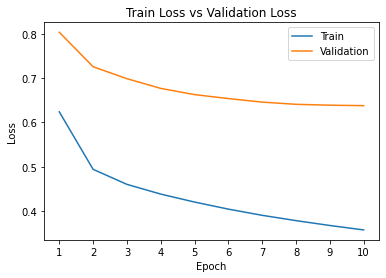

In [109]:
plt.plot(split_df['epochs'], split_df['train_loss'], label='Train')
plt.plot(split_df['epochs'], split_df['val_loss'], label='Validation')
plt.title('Train Loss vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(split_df['epochs'])
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig('/content/loss_graph.png')
plt.show()

Testing of model

In [110]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
val_loss.reset_states()
hidden = decoder.initialize_hidden_state(parameters['batch_size'], parameters['rnn_size'])
for (batch, (inp, tar)) in enumerate(test_dataset.take(parameters['test_steps'])):
    new_inp = image_batch_generator(inp)
    validation_step(new_inp, tar, encoder, decoder, tar_word_index, parameters['batch_size'], hidden)
print('Test Loss=', round(val_loss.result().numpy(), 3))

Test Loss= 0.628


Function for predicting the caption using image path

In [129]:
def predict(image_path, new_model):
    extracted_feature = preprocess_image(image_path, new_model)
    tar_word_index = open_file('/content/tar-word-index')
    tar_index_word = open_file('/content/tar-index-word')
    parameters = open_file('/content/parameters')
    encoder = Encoder(parameters['emb_size'], parameters['rate'])
    decoder = Decoder(parameters['emb_size'], parameters['tar_vocab_size'], parameters['rnn_size'], parameters['rate'])
    checkpoint_dir = '/content/training_checkpoints'
    checkpoint = tf.train.Checkpoint(encoder=encoder, decoder=decoder)
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
    hidden = decoder.initialize_hidden_state(1, parameters['rnn_size'])
    enc_out = encoder(extracted_feature, False)
    dec_inp = tf.expand_dims([tar_word_index['<s>']], 0)
    caption = []
    for i in range(1, 100):
        prediction, hidden = decoder(dec_inp, hidden, enc_out, False)
        predicted_id = tf.argmax(prediction[0]).numpy()
        if tar_index_word[predicted_id] != '</s>':
            caption.append(tar_index_word[predicted_id])
        else:
            break
        dec_inp = tf.expand_dims([predicted_id], 0)
    caption = sp.DecodePieces(caption)
    caption = caption.replace('▁', ' ')
    return caption

Suppress Tensorflow warning during prediction

In [131]:
import os
import logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger('tensorflow').setLevel(logging.FATAL)

Predicting the caption for the image in testing set

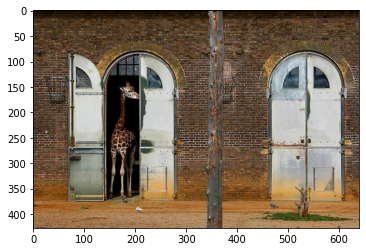

In [133]:
image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % int(test_image_id[0])
img = np.array(Image.open(image_path))
plt.imshow(img)

In [132]:
print('Original Caption: ', test_captions[0])
print('Prediction Caption: ', predict(image_path, new_model))

Original Caption:  a giraffe stands in the doorway of a building .
Prediction Caption:  a man is standing in the grass with his dog .


Predicting the caption for the image in testing set

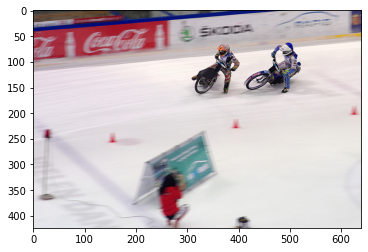

In [134]:
image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % int(test_image_id[1])
img = np.array(Image.open(image_path))
plt.imshow(img)

In [137]:
print('Original Caption: ', test_captions[1])
print('Prediction Caption: ', predict(image_path, new_model))

Original Caption:  two men riding motorocycles on ice next to a coca cola sign .
Prediction Caption:  a man is riding a skateboard down a street .


The main references used for developing this project are given below:

1. Xu, Kelvin, et al. "Show, attend and tell: Neural image caption generation with visual attention." International conference on machine learning. 2015.

2. Luong, Minh-Thang, Hieu Pham, and Christopher D. Manning. "Effective approaches to attention-based neural machine translation." arXiv preprint arXiv:1508.04025 (2015).

3. Kudo, Taku, and John Richardson. "Sentencepiece: A simple and language independent subword tokenizer and detokenizer for neural text processing." arXiv preprint arXiv:1808.06226 (2018).

The main contribution of this project is to use all the words in the corpus, instead of dropping some rare words. For this purpose we use SentencePiece tokenizer with the vocabulary size of 2048, which would help in splitting rare words into subword tokens. It also helps in reducing the vocabulary size of the corpus thereby reducing the number of units required in the last layer or top layer of the decoder.

A more clear explanation is given in https://preetham-ganesh.medium.com/image-captioning-using-luong-attention-and-sentencepiece-tokenizer-2658b0e6f887 (Report / Blogpost)

The notebook can be downloaded at https://github.com/preetham7897/website/blob/master/documents/ganesh_term_project.ipynb 
